# HMS II.3 Calibration
This notebook studies the possibility of calibrating HMS II.3 measurements to GRAS 43/45 measurements

## Setup
Run these blocks to load dependencies, set up paths, load targets and reference measurements

In [ ]:
%load_ext autoreload
%autoreload 2

In [10]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from autoeq.frequency_response import FrequencyResponse
from autoeq.peq import PEQ, Peaking
from calibration import calibrate

In [3]:
DIR_PATH = Path().resolve()
AUTOEQ_PATH = DIR_PATH.parent.parent.joinpath('AutoEq')
DIR_PATH.joinpath('out').mkdir(parents=True, exist_ok=True)

In [4]:
harman = {
    'over-ear': FrequencyResponse.read_csv(AUTOEQ_PATH.joinpath('targets', 'Harman over-ear 2018 without bass.csv')),
    'in-ear': FrequencyResponse.read_csv(AUTOEQ_PATH.joinpath('targets', 'Harman in-ear 2019 without bass.csv'))
}
references = {
    'over-ear': [FrequencyResponse.read_csv(fp) for fp in AUTOEQ_PATH.joinpath('measurements', 'oratory1990', 'data', 'over-ear').glob('*.csv')],
    'in-ear': [FrequencyResponse.read_csv(fp) for fp in AUTOEQ_PATH.joinpath('measurements', 'oratory1990', 'data', 'in-ear').glob('*.csv')]
}
ie_ref_names = [fr.name for fr in references['in-ear']]
for fp in AUTOEQ_PATH.joinpath('measurements', 'crinacle', 'data', 'in-ear', '711').glob('*.csv'):
    if fp.name.replace('.csv', '') not in ie_ref_names:
        references['in-ear'].append(FrequencyResponse.read_csv(fp))
        ie_ref_names.append(fp.name.replace('.csv', ''))
references = {
    'over-ear': {fr.name: fr for fr in references['over-ear']},
    'in-ear': {fr.name: fr for fr in references['in-ear']},
}

## Calibration
This section has three tests for Headphone.com Legacy, Innerfidelity and Rtings measurements:

1. Individual differences between frequency responses of all in-ear headphones measured on the two systems
2. Arithmetic mean and standard deviation of the individual differences
3. Calibration of Harman 2019 in-ear target to Bruel & Kjaer 4620 measurements

We can observe that most of the spectrum the mean calibration is less than standard deviation. This indicates that
calibrating the measurements wouldn't be necessary. However, we do notice a systematic drop between 5 and 8 kHz
and in many cases an elevation at 3.5 kHz. It's hard to say if those should be calibrated or not just yet.
Elevating ear gain region is often a dangerous excercise since people tend to complain when the region is too hot.
Reduction in the region, and in treble region in general, tends to produce less complaints, at least anecdotally
speaking.

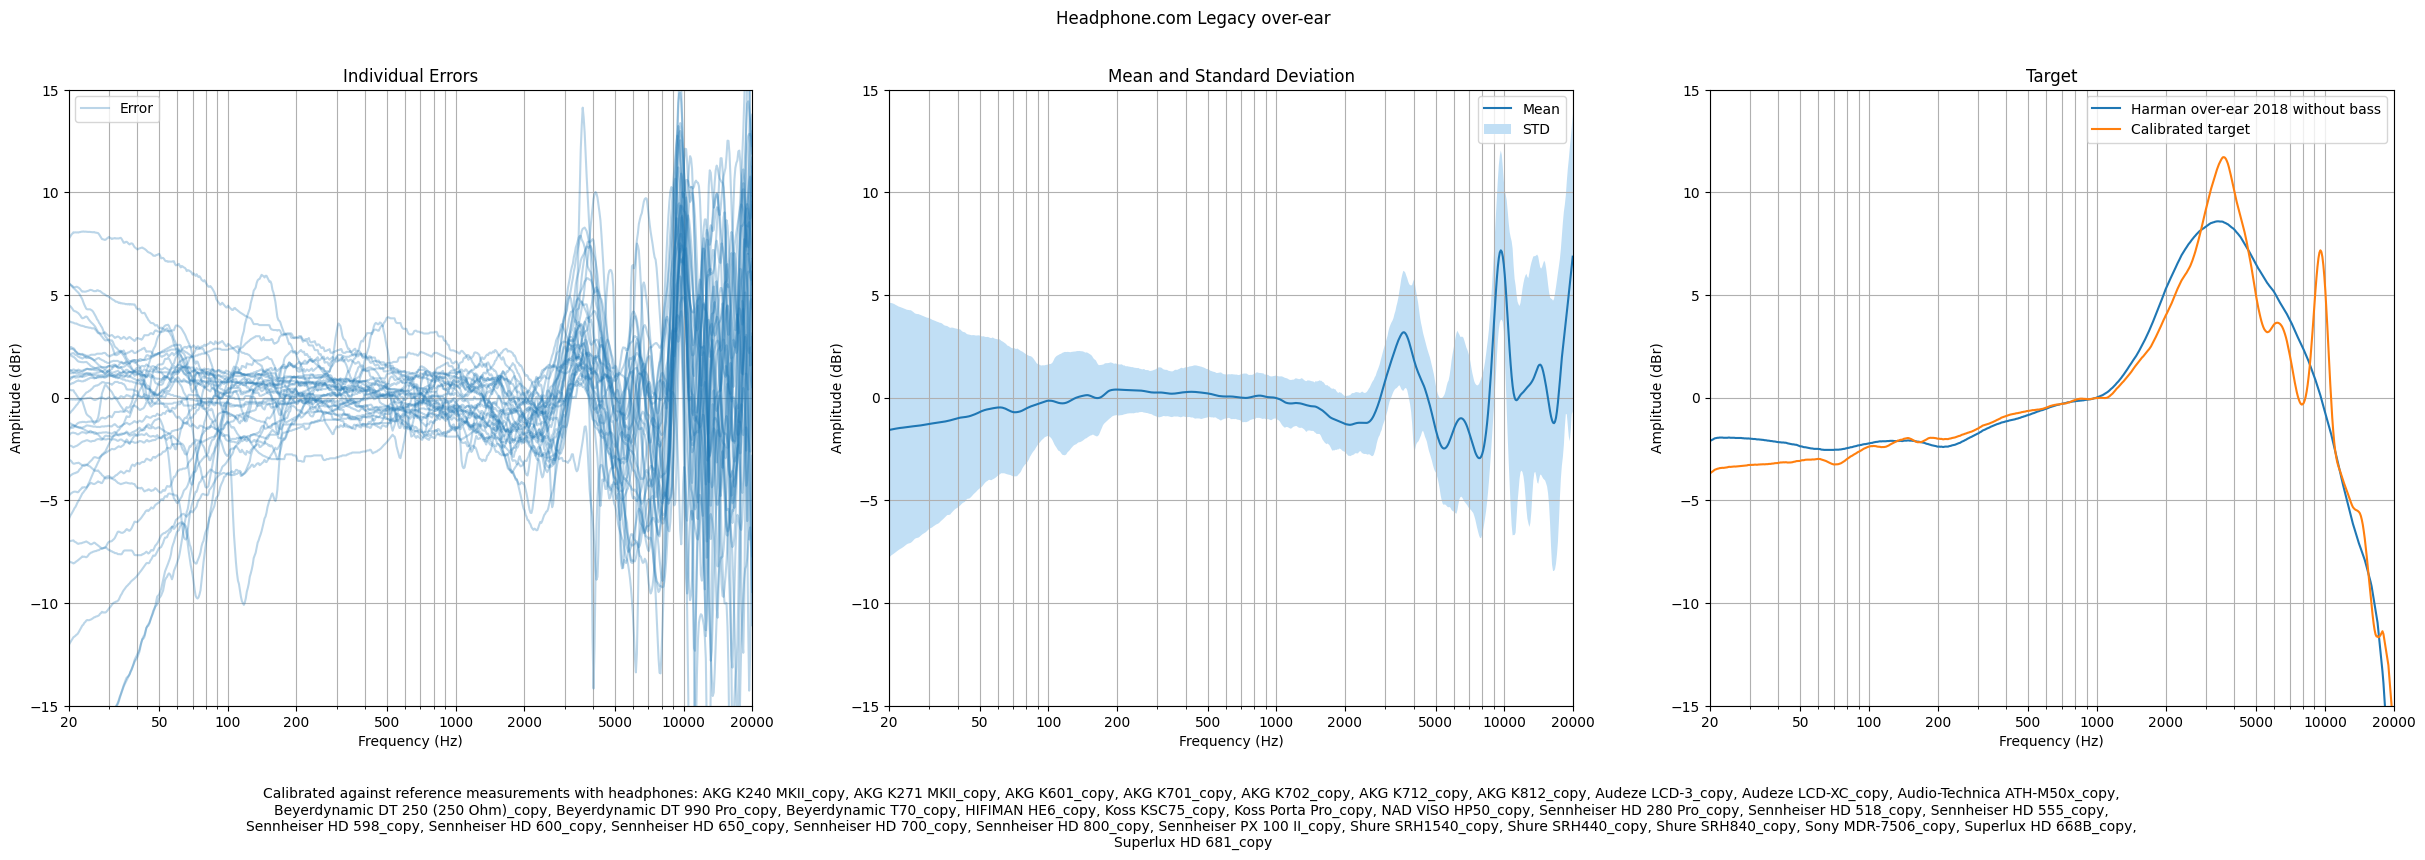

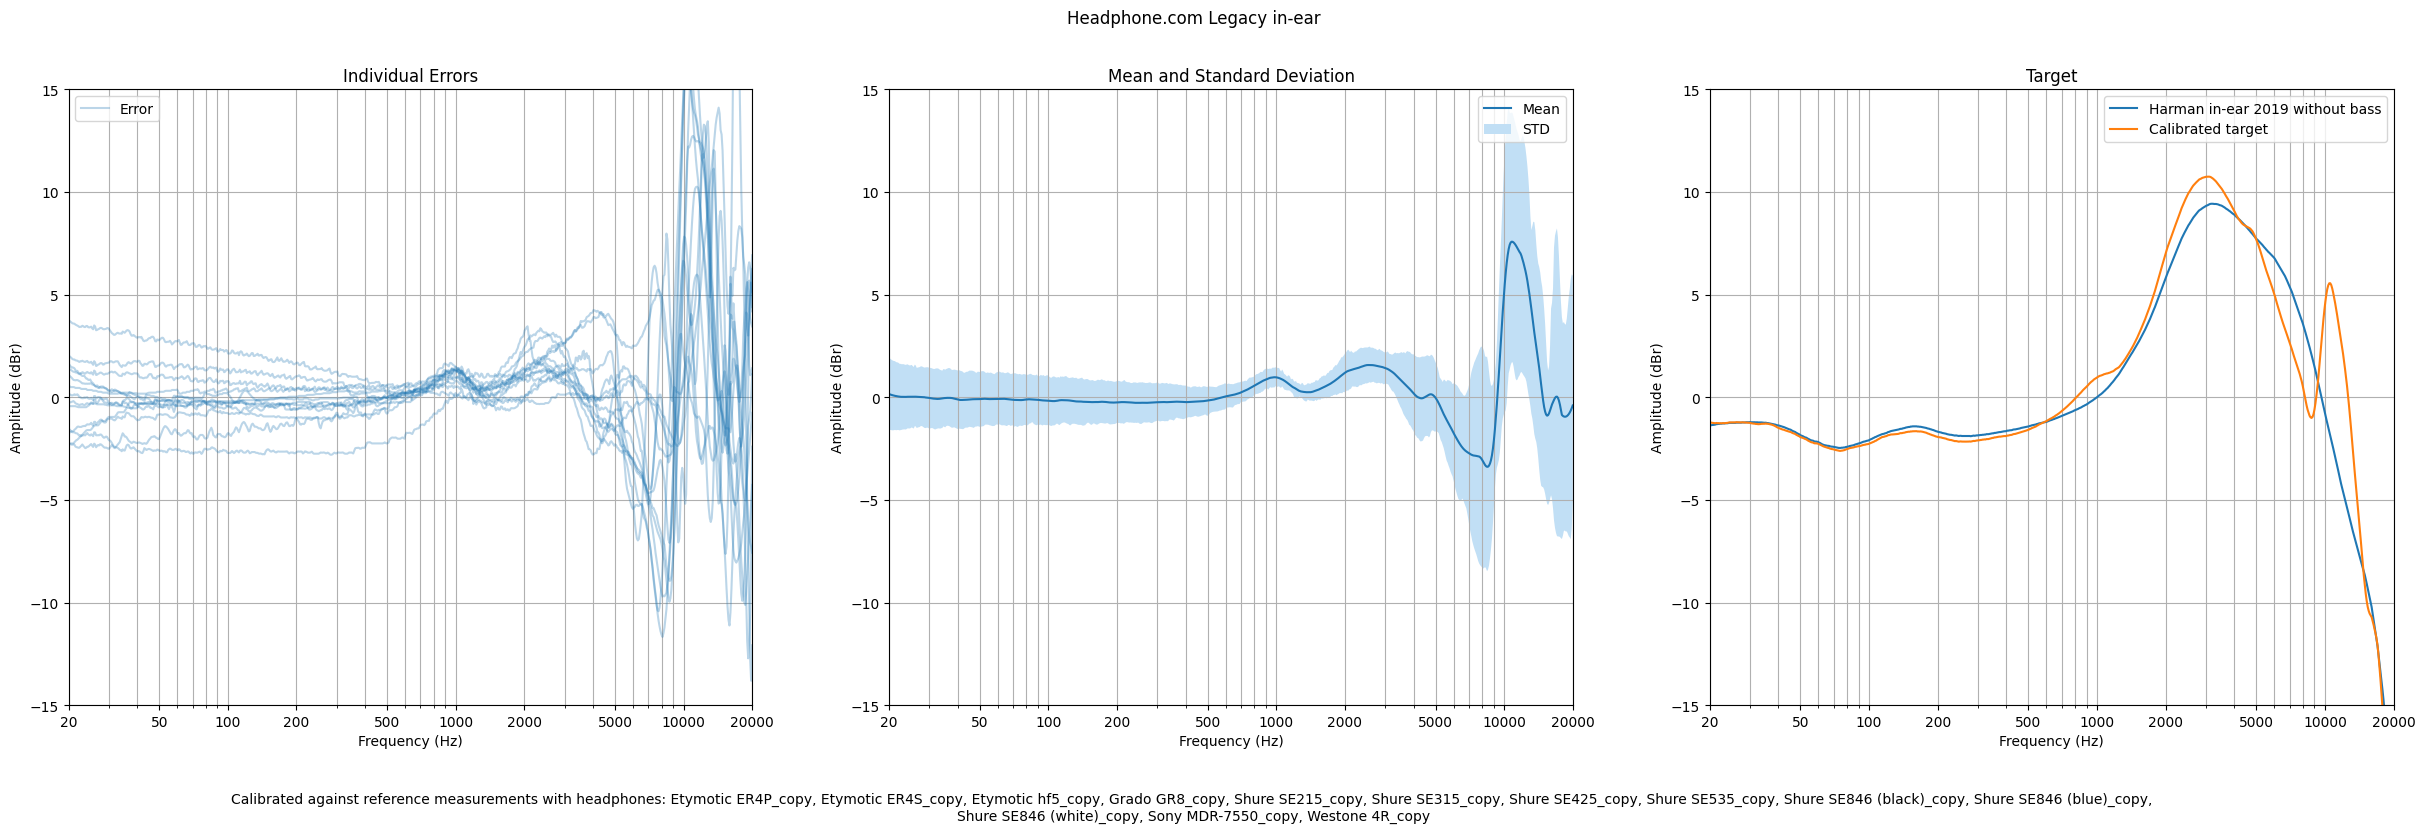

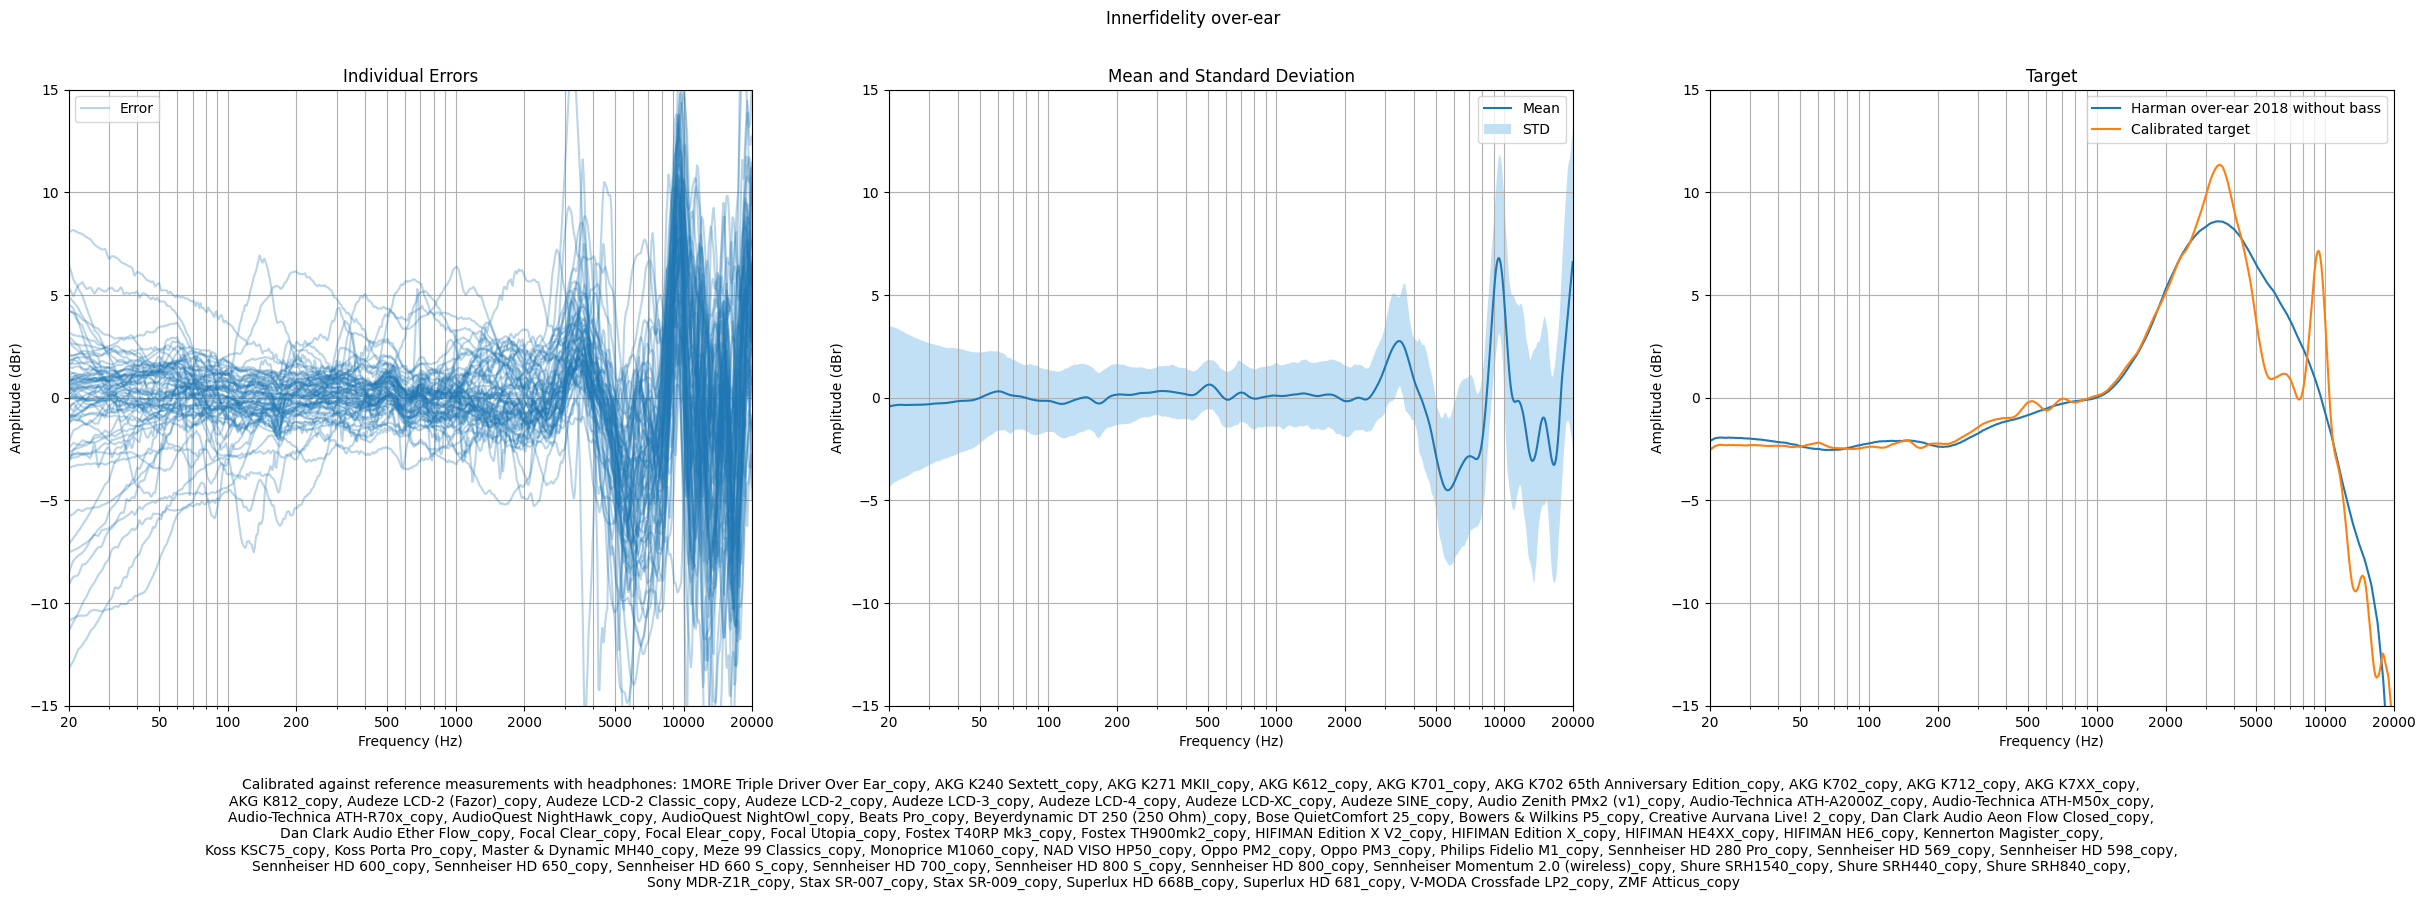

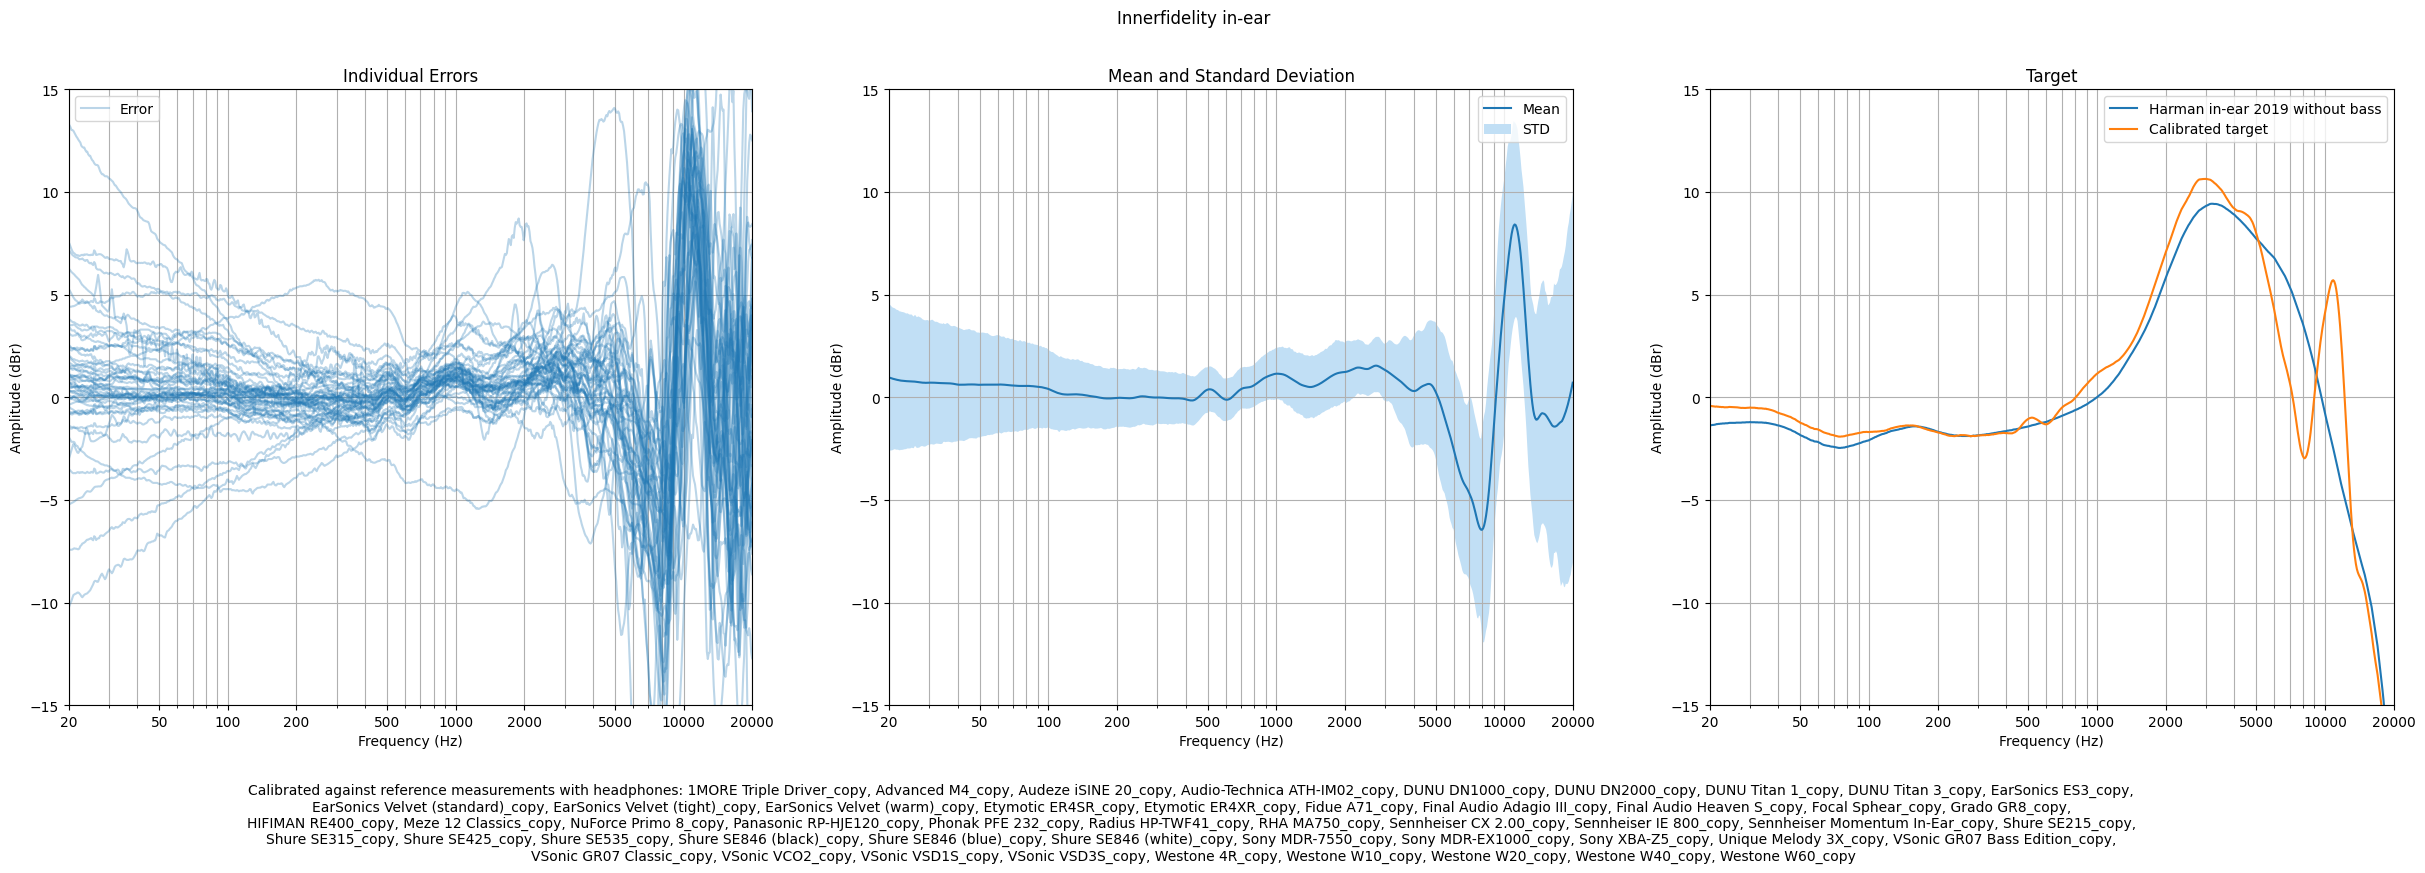

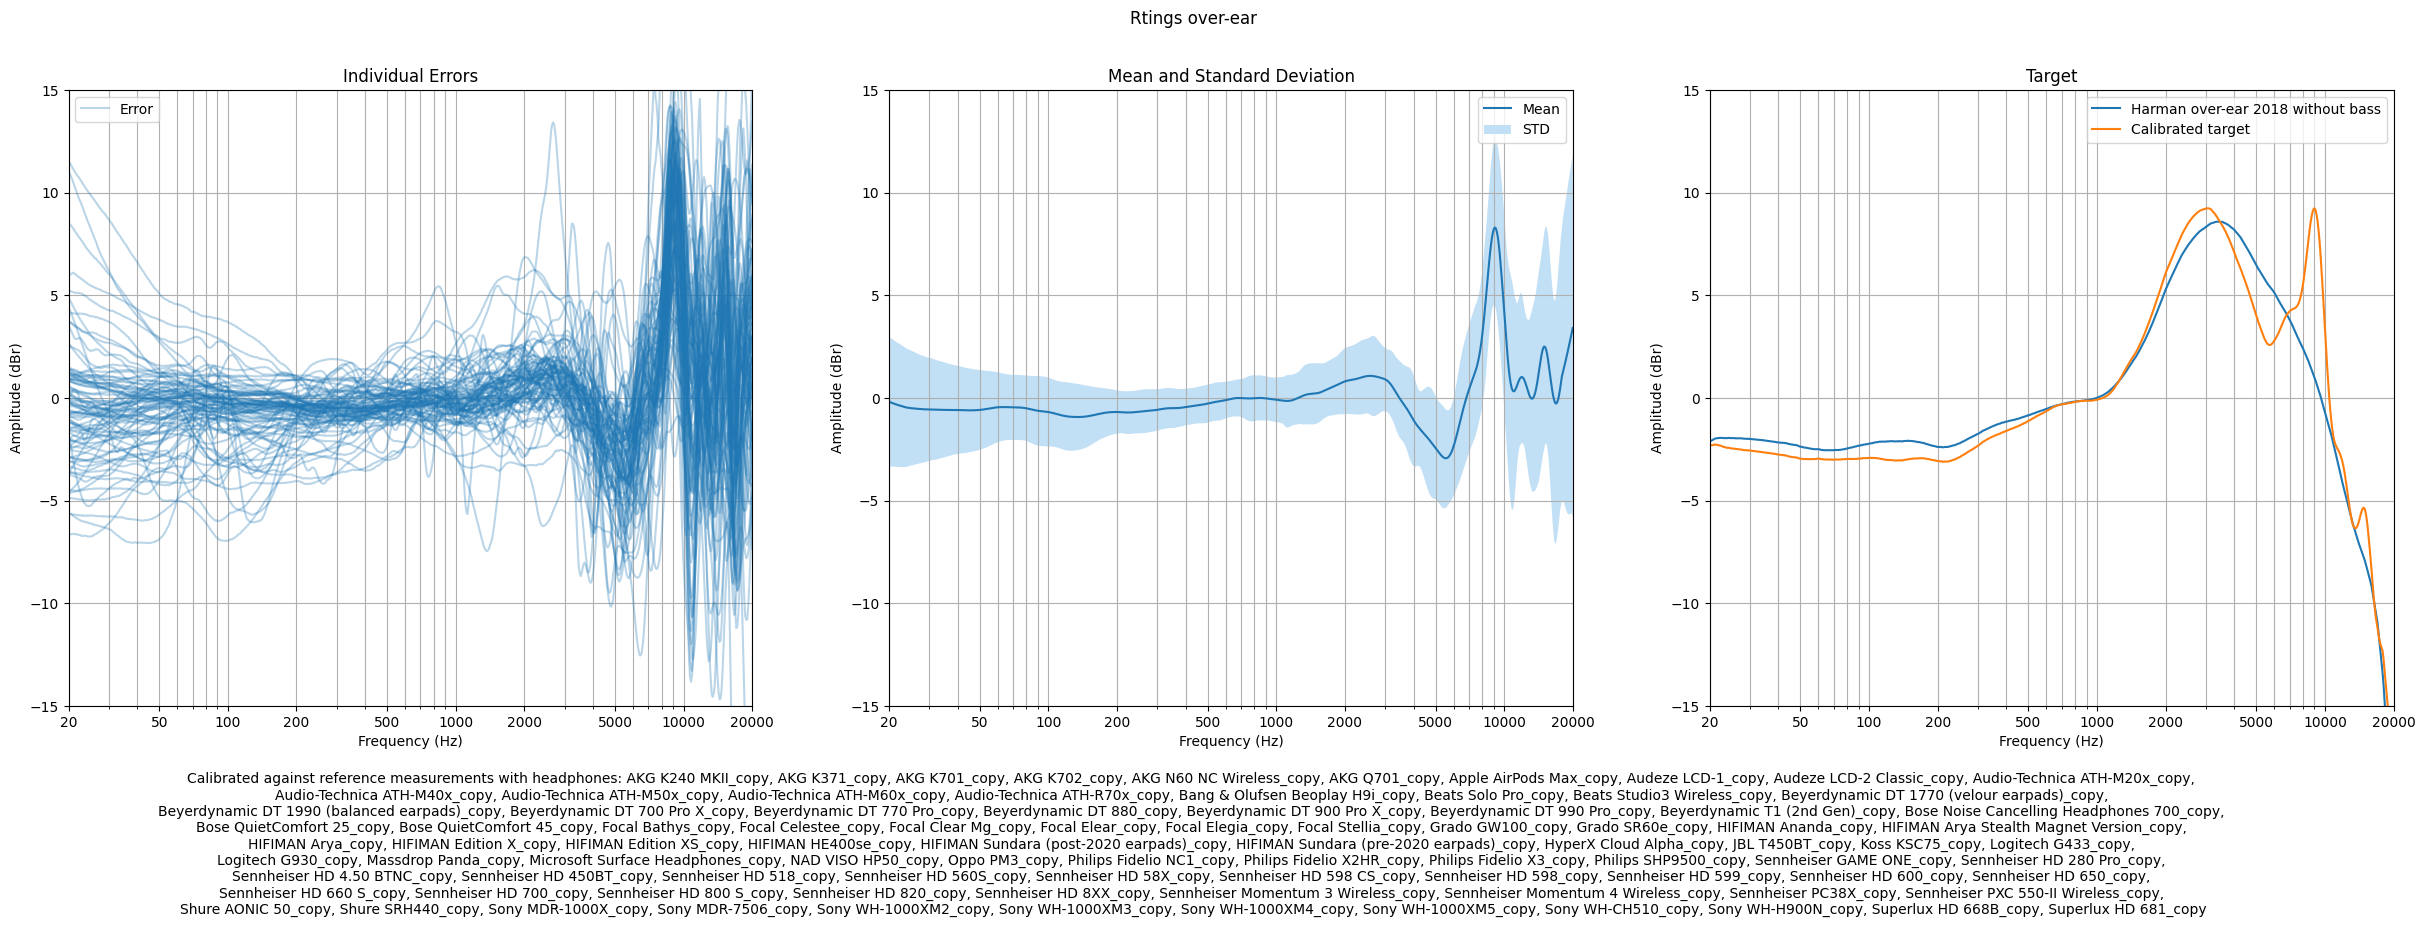

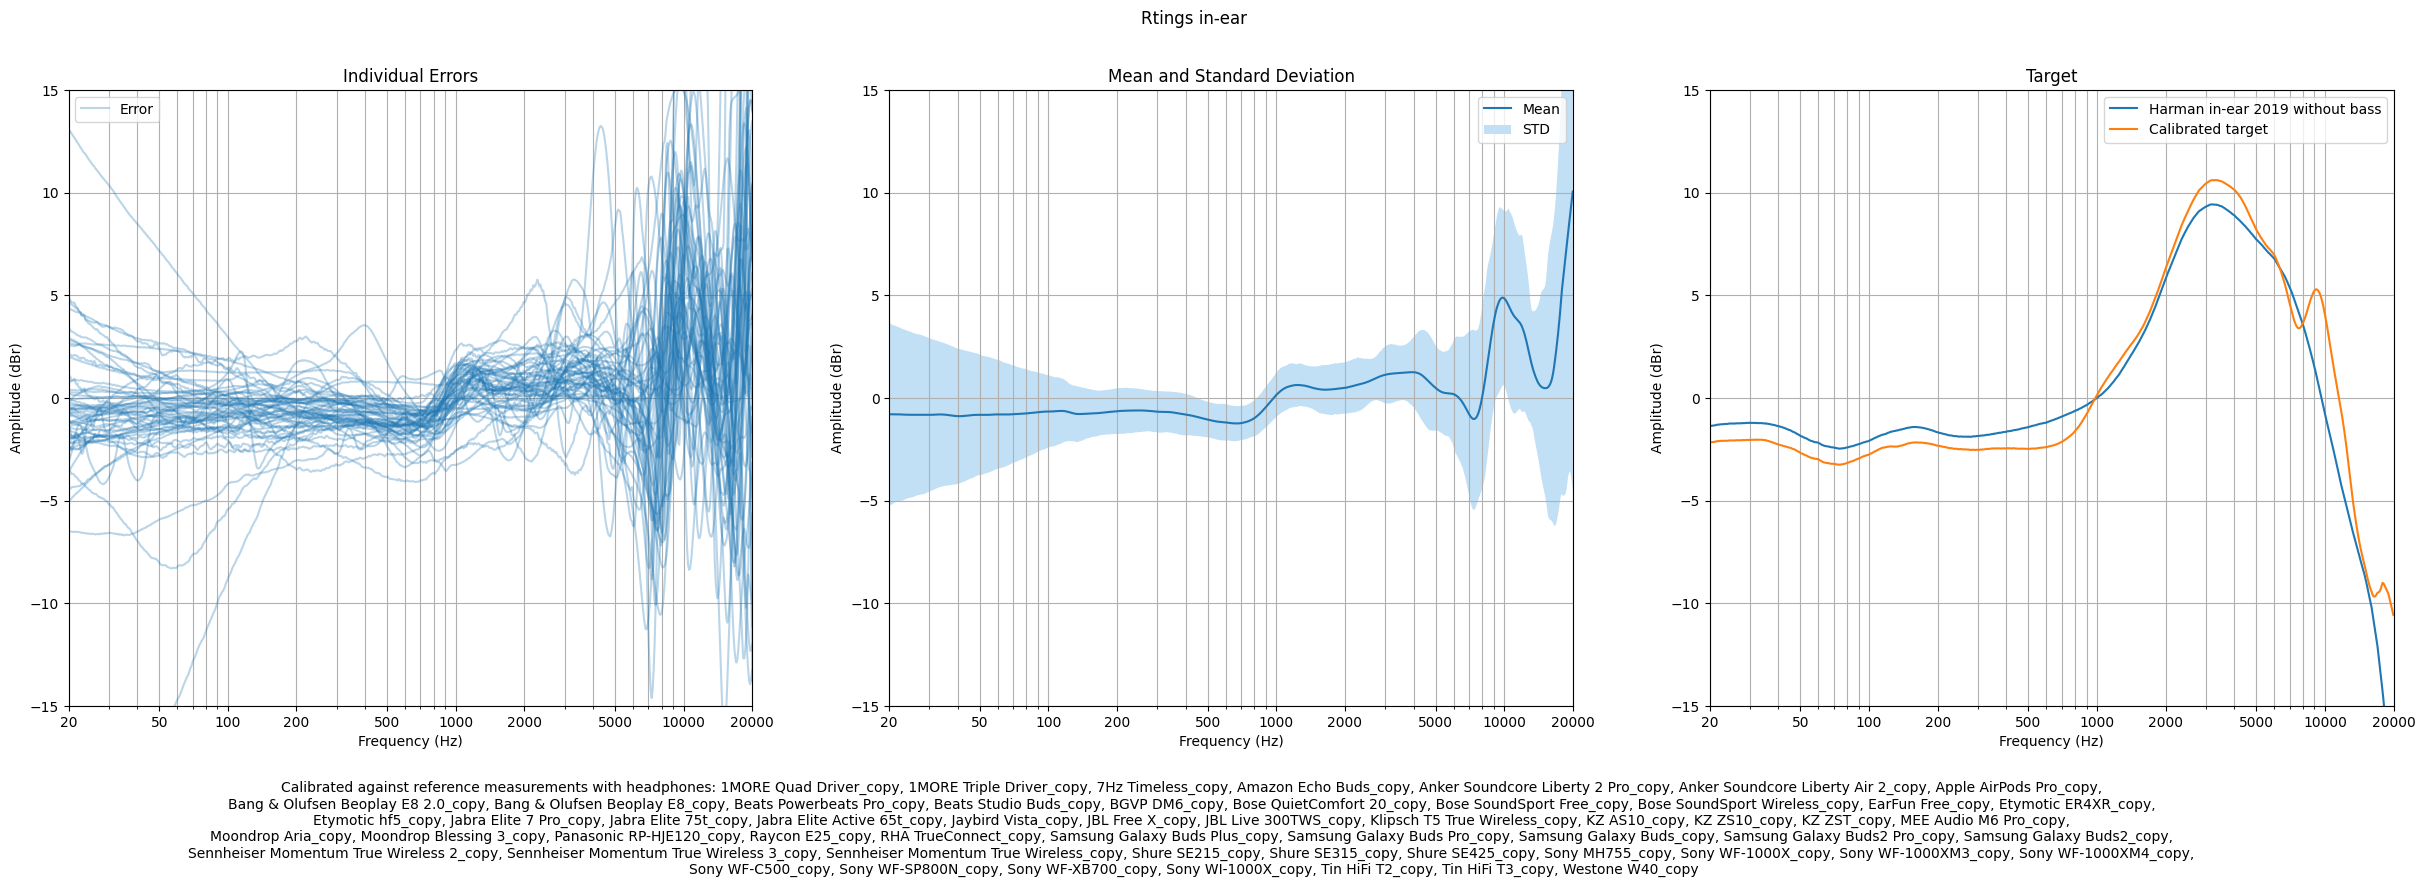

In [6]:
for db in ['Headphone.com Legacy', 'Innerfidelity', 'Rtings']:
    for form in ['over-ear', 'in-ear']:
        frs = [FrequencyResponse.read_csv(fp) for fp in AUTOEQ_PATH.joinpath('measurements', db, 'data', form).glob('*.csv')]
        errors, mean, calibrated_target, fig = calibrate(db, form, frs, references[form], harman[form])
        #fig.savefig(DIR_PATH.joinpath('out', f'Calibration {db} {harman[form].name}.png'), bbox_inches='tight')
        mean.write_csv(DIR_PATH.joinpath('out', f'{db} {form} calibration.csv'))
        plt.show()
        plt.close(fig)

## Comparing old and new calibration curves
This calibration execrise was done earlier. Have the calibration curves changed as more headphones have been measured?

Based on these observations, we can conclude that they haven't significantly changed.

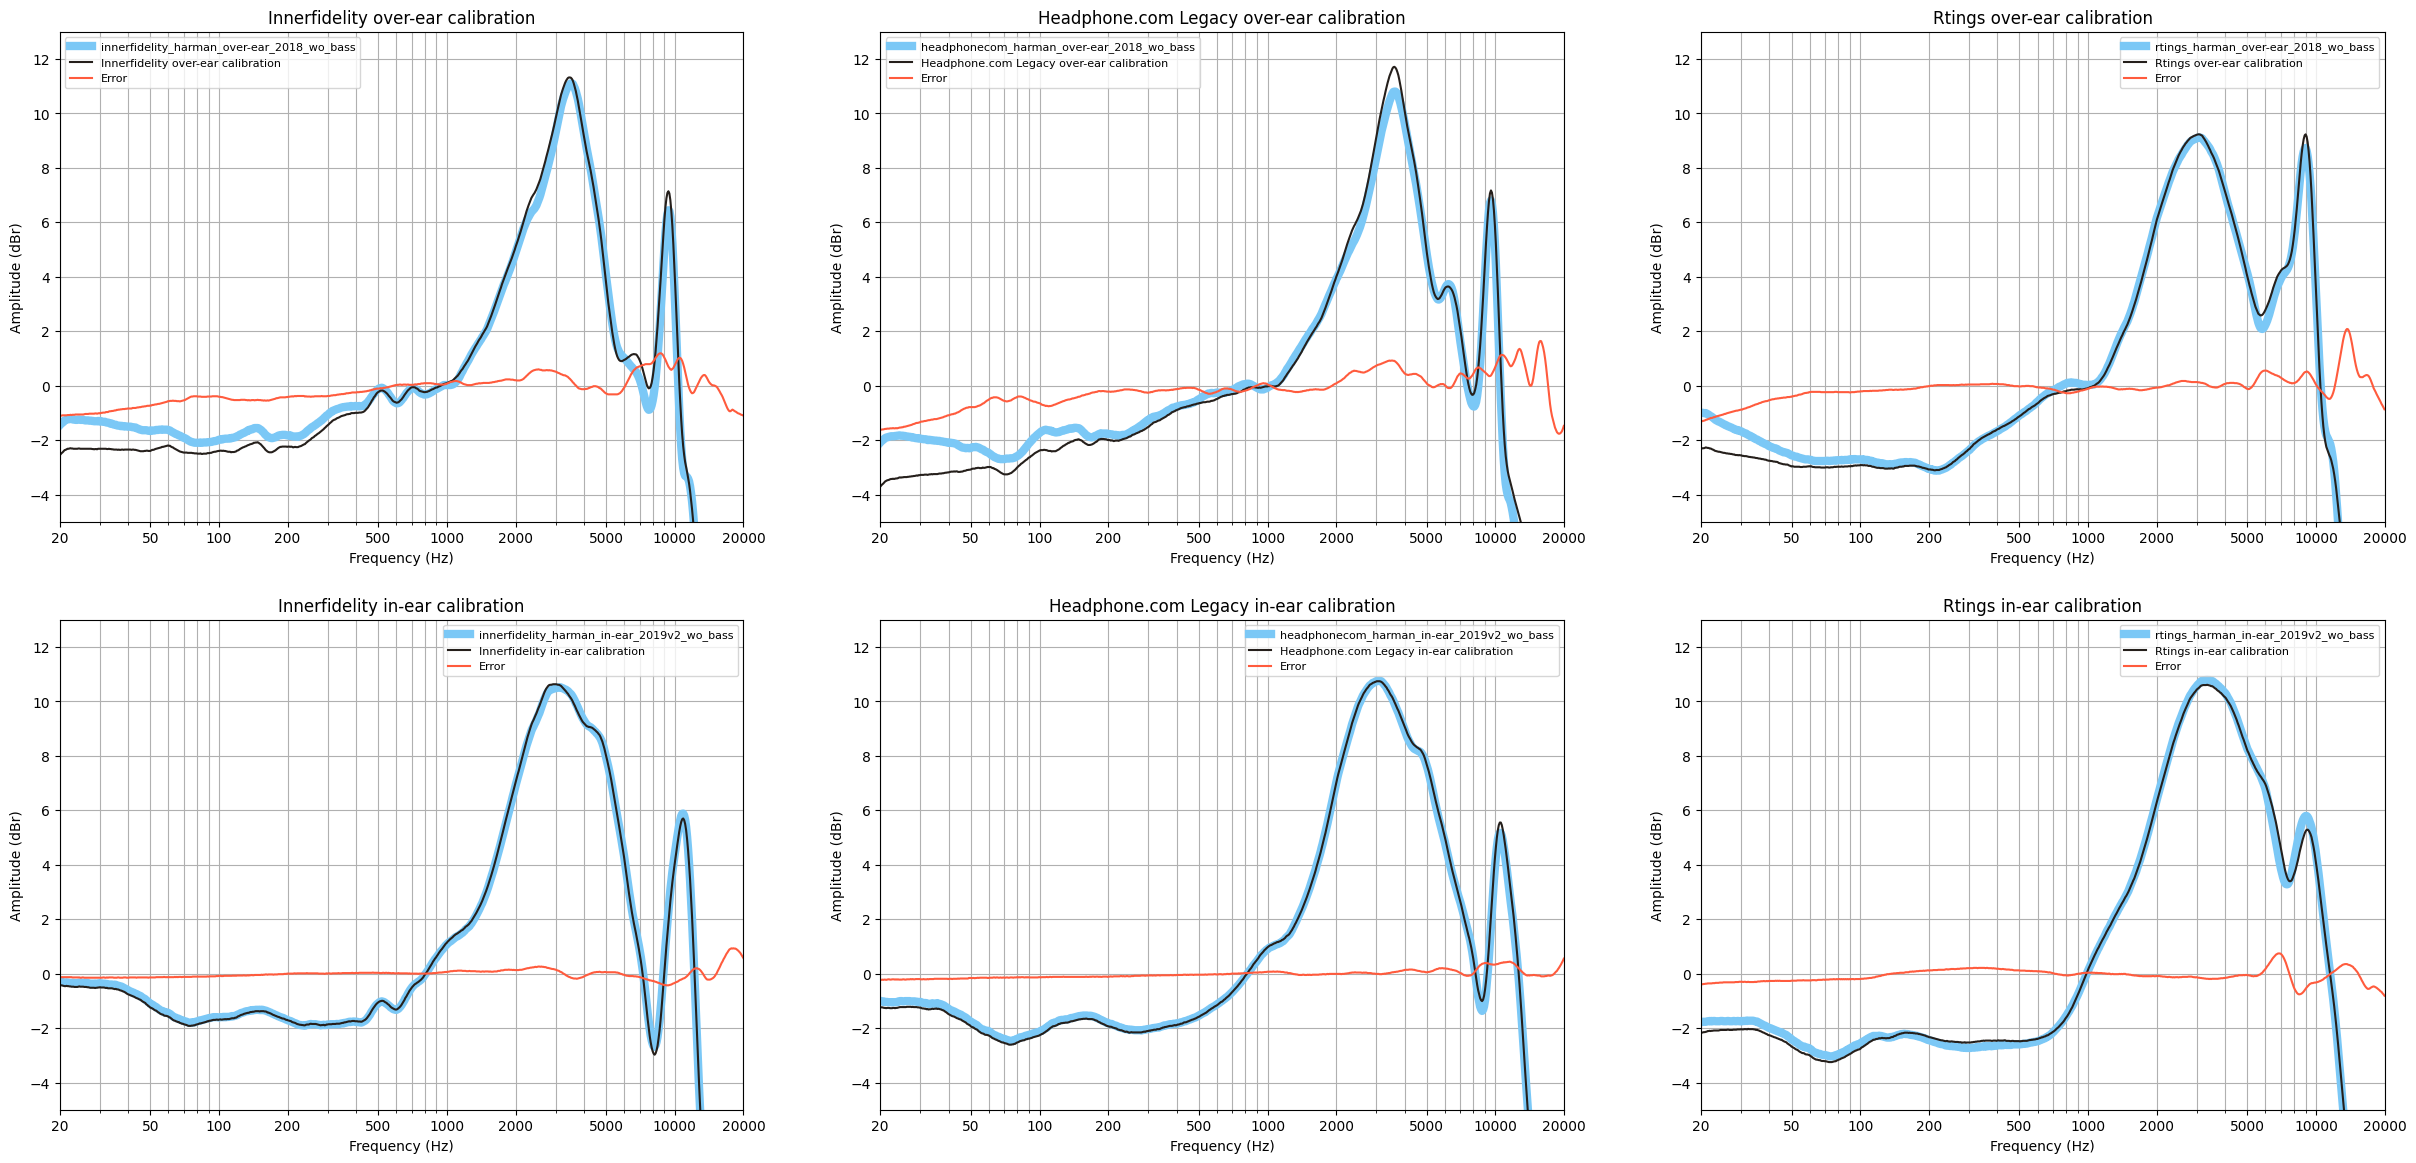

In [7]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(30, 14)
name_pairs = [('innerfidelity', 'Innerfidelity'), ('headphonecom', 'Headphone.com Legacy'), ('rtings', 'Rtings')]
for i, pair in enumerate(name_pairs):
    old_name, new_name = pair
    oe_old = FrequencyResponse.read_csv(f'old/{old_name}_harman_over-ear_2018_wo_bass.csv')
    oe_new = FrequencyResponse.read_csv(f'out/{new_name} over-ear calibration.csv')
    oe_new.raw += harman['over-ear'].raw
    oe_new.compensate(oe_old, min_mean_error=True)
    oe_new.plot(fig=fig, ax=axs[0, i], show_fig=False, raw_plot_kwargs={'label': oe_new.name}, target_plot_kwargs={'label': oe_old.name})
    axs[0, i].set_ylim([-5, 13])
    ie_old = FrequencyResponse.read_csv(f'old/{old_name}_harman_in-ear_2019v2_wo_bass.csv')
    ie_new = FrequencyResponse.read_csv(f'out/{new_name} in-ear calibration.csv')
    ie_new.raw += harman['in-ear'].raw
    ie_new.compensate(ie_old, min_mean_error=True)
    ie_new.plot(fig=fig, ax=axs[1, i], show_fig=False, raw_plot_kwargs={'label': ie_new.name}, target_plot_kwargs={'label': ie_old.name})
    axs[1, i].set_ylim([-5, 13])
plt.show()

# Comparing calibration curves
The calibration curves look quite similar across different sources, but how similar exactly? This section inspects the
difference between the calibration curves with the hope that a single curve would serve all over-ear measurements and
another all in-ear measurements.

Innerfidelity and Headphone.com calibration curves look almost indentical while Rtings is slightly different.

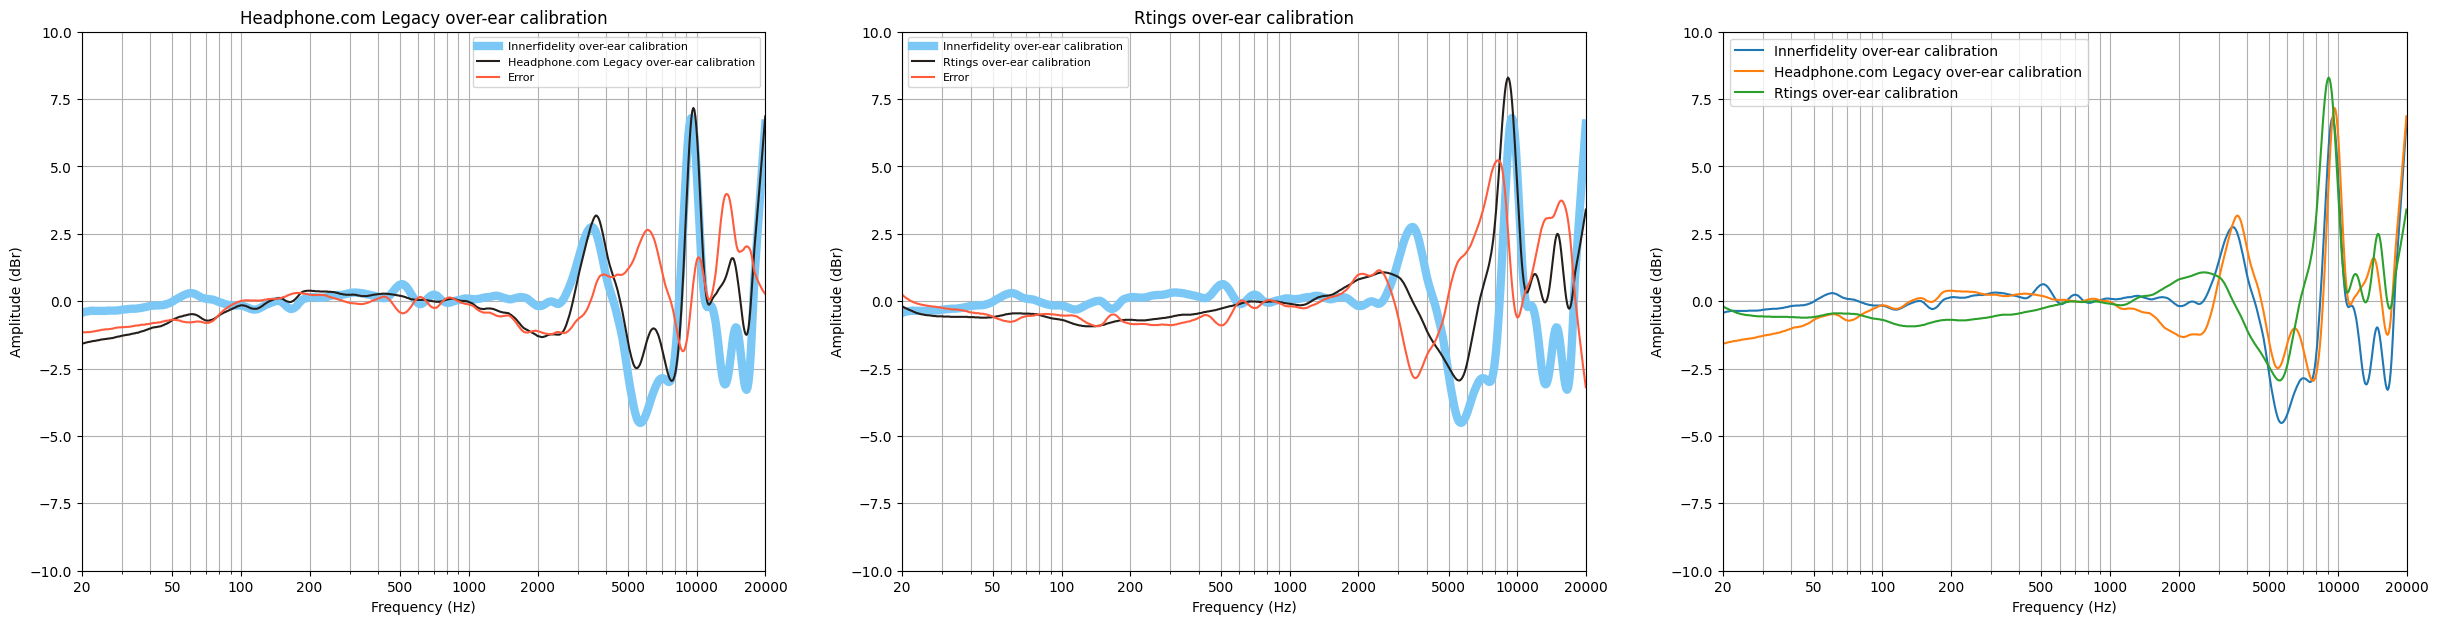

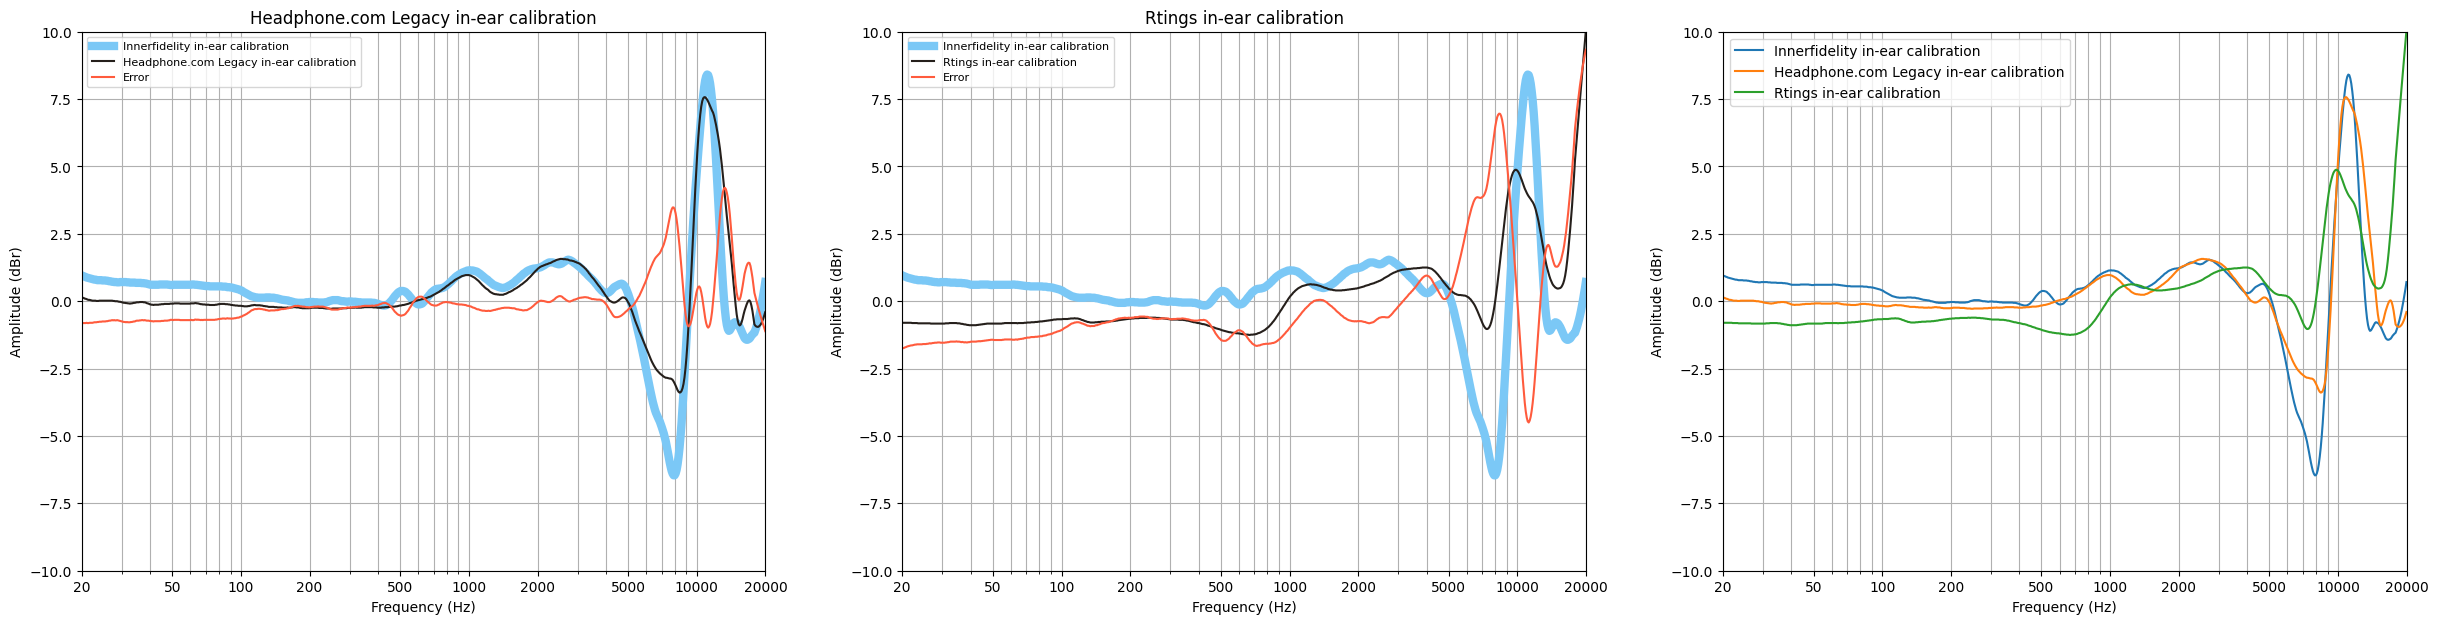

In [8]:
if_oe = FrequencyResponse.read_csv(f'out/Innerfidelity over-ear calibration.csv')
hp_oe = FrequencyResponse.read_csv(f'out/Headphone.com Legacy over-ear calibration.csv')
rt_oe = FrequencyResponse.read_csv(f'out/Rtings over-ear calibration.csv')
if_ie = FrequencyResponse.read_csv(f'out/Innerfidelity in-ear calibration.csv')
hp_ie = FrequencyResponse.read_csv(f'out/Headphone.com Legacy in-ear calibration.csv')
rt_ie = FrequencyResponse.read_csv(f'out/Rtings in-ear calibration.csv')
for i, targets in enumerate([[if_oe, hp_oe, rt_oe], [if_ie, hp_ie, rt_ie]]):
    targets[1].compensate(targets[0], min_mean_error=True)
    targets[2].compensate(targets[0], min_mean_error=True)
    fig, axs = plt.subplots(1, 3)
    fig.set_size_inches(30, 7)
    targets[1].plot(fig=fig, ax=axs[0], show_fig=False, raw_plot_kwargs={'label': targets[1].name}, target_plot_kwargs={'label': targets[0].name})
    targets[2].plot(fig=fig, ax=axs[1], show_fig=False, raw_plot_kwargs={'label': targets[2].name}, target_plot_kwargs={'label': targets[0].name})
    targets[0].init_plot(fig=fig, ax=axs[2])
    axs[2].plot(targets[0].frequency, targets[0].raw, label=targets[0].name)
    axs[2].plot(targets[1].frequency, targets[1].raw, label=targets[1].name)
    axs[2].plot(targets[2].frequency, targets[2].raw, label=targets[2].name)
    axs[2].legend()
    axs[0].set_ylim([-10, 10])
    axs[1].set_ylim([-10, 10])
    axs[2].set_ylim([-10, 10])
plt.show()

# Approximating calibration curves with biquad filters
Some elements of the calibration curves are definitely artifacts of the measurement systems used. For example
the massive spike at around 9 kHz is most likely the ear resonance of the GRAS couplers which doesn't seem
to appear with HMS II.3 measurements. This should not be added to the calibration curve.

This section aims to find a very limited set of biquad filters that would approximate the desired elements
of the calibration curves accurately (but conservatively) enough. For over-ear measurements, the 3.5 kHz
peak should be ignored as it's very narrow and it's dangerous to add those kind of boosts to the region,
while introducing similar cut is barely audible at all. Therefore we only add a single filter at 5500 Hz
to account for the rather significant dips in the calibration curves. Whether this is needed in reality
is uncertain but, as mentioned, unnecessary narrow cuts aren't very audible so the risk of adding it is
smaller than the risk of ignoring it.

The same filter is used for all sources. It's a very approximate solution and nothing more precise is
justified with the available data so also varying the filter parameters for the different sources is not
justified either.

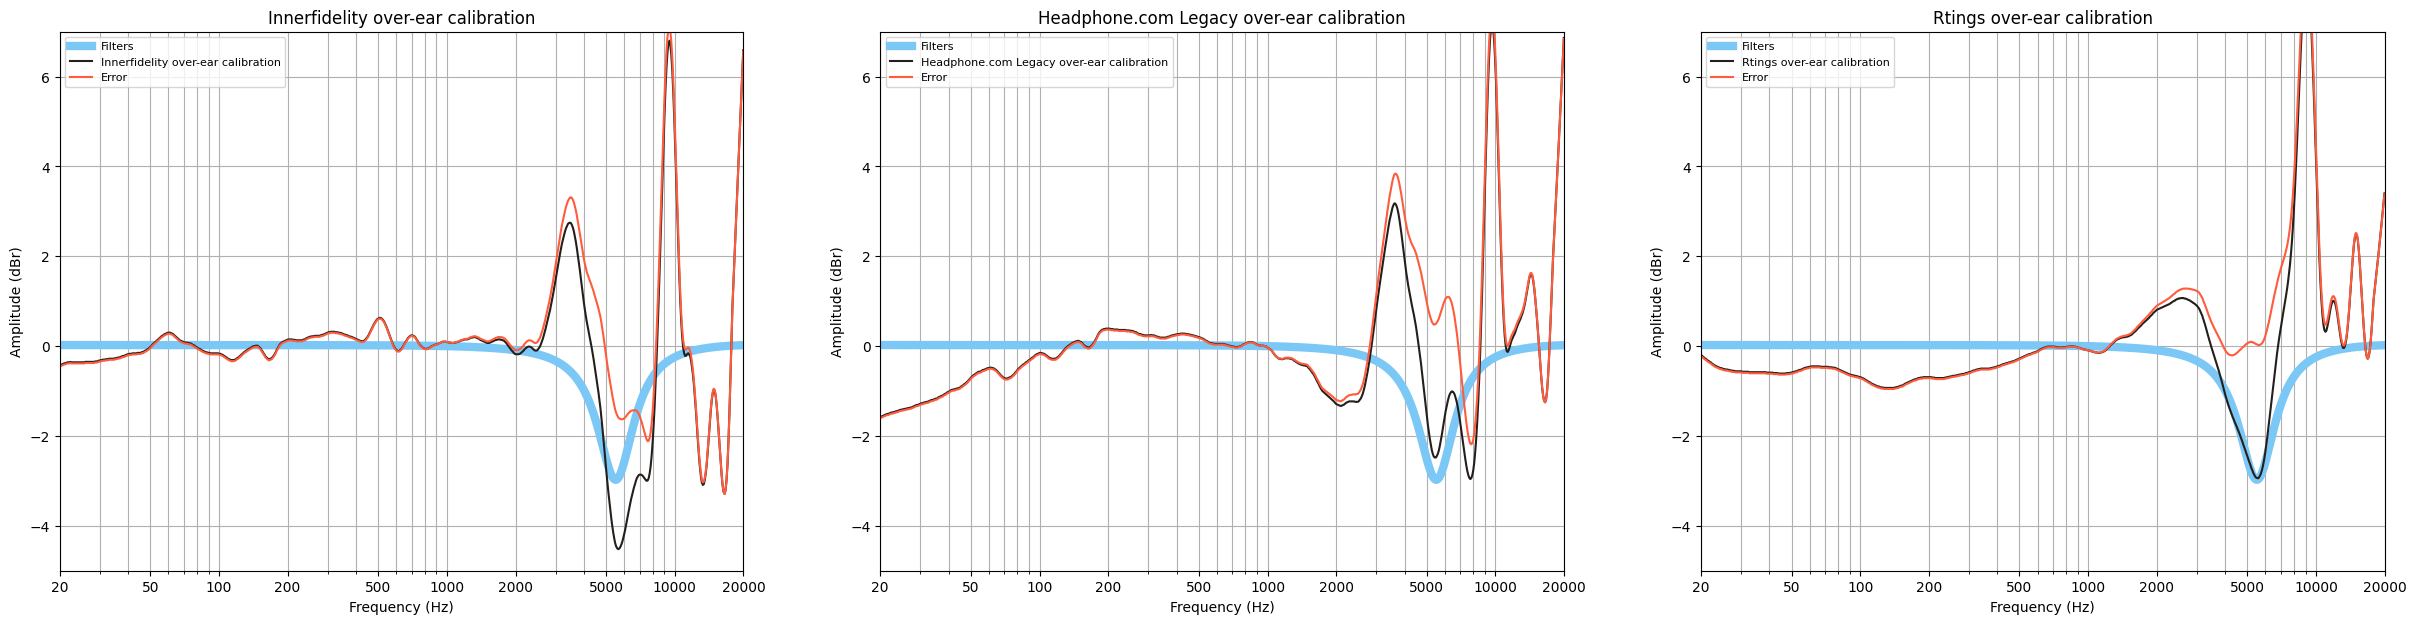

In [29]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(30, 7)
peq = PEQ(if_oe.frequency, 44100, [Peaking(if_oe.frequency, 44100, fc=3000, q=1.4, gain=0), Peaking(if_oe.frequency, 44100, fc=5500, q=2, gain=-3)])
cal_oe = FrequencyResponse(name='PEQ', frequency=if_oe.frequency, raw=peq.fr)
if_oe.compensate(cal_oe, min_mean_error=False)
hp_oe.compensate(cal_oe, min_mean_error=False)
rt_oe.compensate(cal_oe, min_mean_error=False)
if_oe.plot(fig=fig, ax=axs[0], show_fig=False, raw_plot_kwargs={'label': if_oe.name}, target_plot_kwargs={'label': 'Filters'})
hp_oe.plot(fig=fig, ax=axs[1], show_fig=False, raw_plot_kwargs={'label': hp_oe.name}, target_plot_kwargs={'label': 'Filters'})
rt_oe.plot(fig=fig, ax=axs[2], show_fig=False, raw_plot_kwargs={'label': rt_oe.name}, target_plot_kwargs={'label': 'Filters'})
axs[0].set_ylim([-5, 7])
axs[1].set_ylim([-5, 7])
axs[2].set_ylim([-5, 7])
plt.show()

### In-ear
Same thing, but for in-ear measurements.

Here we add a small boost of 1.5 dB at 2500 Hz and a narrow cut at 7 kHz. The 7 kHz cut doesn't cut enough for Innerfidelity
and cuts too much for Rtings while cutting just about right amount for Headphone.com Legacy measurements. A conservative
compromise.

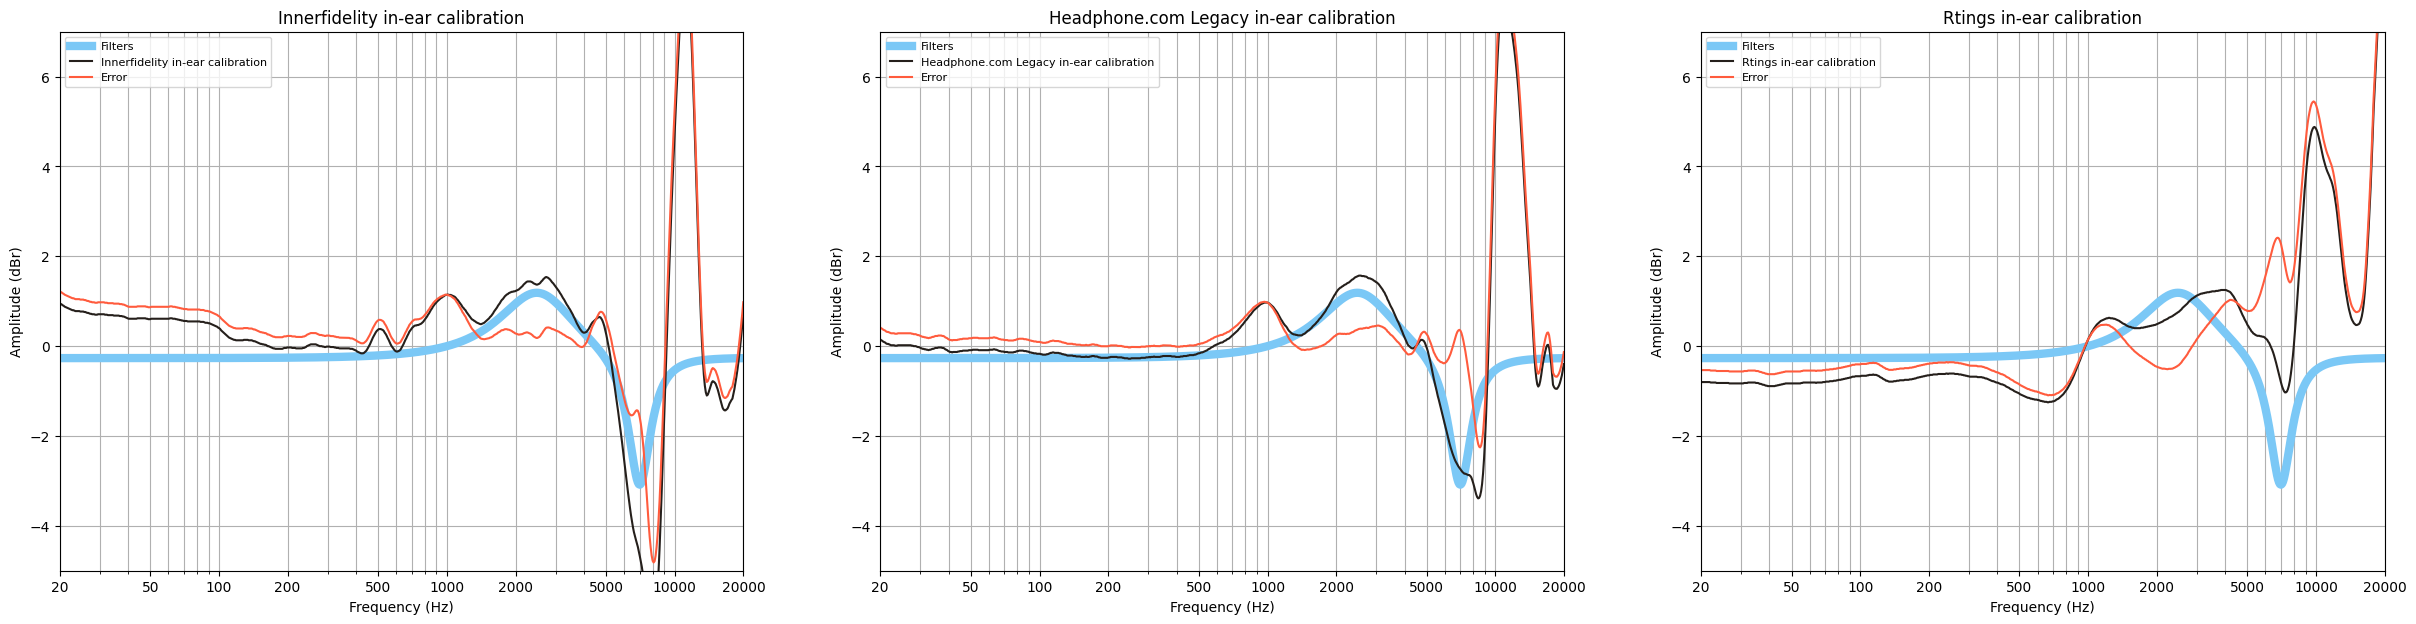

In [22]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(30, 7)
peq = PEQ(if_ie.frequency, 44100, [Peaking(if_ie.frequency, 44100, fc=2500, q=1, gain=1.5), Peaking(if_ie.frequency, 44100, fc=7000, q=3, gain=-3)])
cal_ie = FrequencyResponse(name='PEQ', frequency=if_ie.frequency, raw=peq.fr)
if_ie.compensate(cal_ie, min_mean_error=False)
hp_ie.compensate(cal_ie, min_mean_error=False)
rt_ie.compensate(cal_ie, min_mean_error=False)
if_ie.plot(fig=fig, ax=axs[0], show_fig=False, raw_plot_kwargs={'label': if_ie.name}, target_plot_kwargs={'label': 'Filters'})
hp_ie.plot(fig=fig, ax=axs[1], show_fig=False, raw_plot_kwargs={'label': hp_ie.name}, target_plot_kwargs={'label': 'Filters'})
rt_ie.plot(fig=fig, ax=axs[2], show_fig=False, raw_plot_kwargs={'label': rt_ie.name}, target_plot_kwargs={'label': 'Filters'})
axs[0].set_ylim([-5, 7])
axs[1].set_ylim([-5, 7])
axs[2].set_ylim([-5, 7])
plt.show()

## Target curves
With the calibration filters, in this section we create target curves for HMS II.3. Over-ear measurements get a
target curve based on Harman over-ear 2018 and in-ear measurements get two different targets, one based on 2019
Harman and another on AutoEq house target.

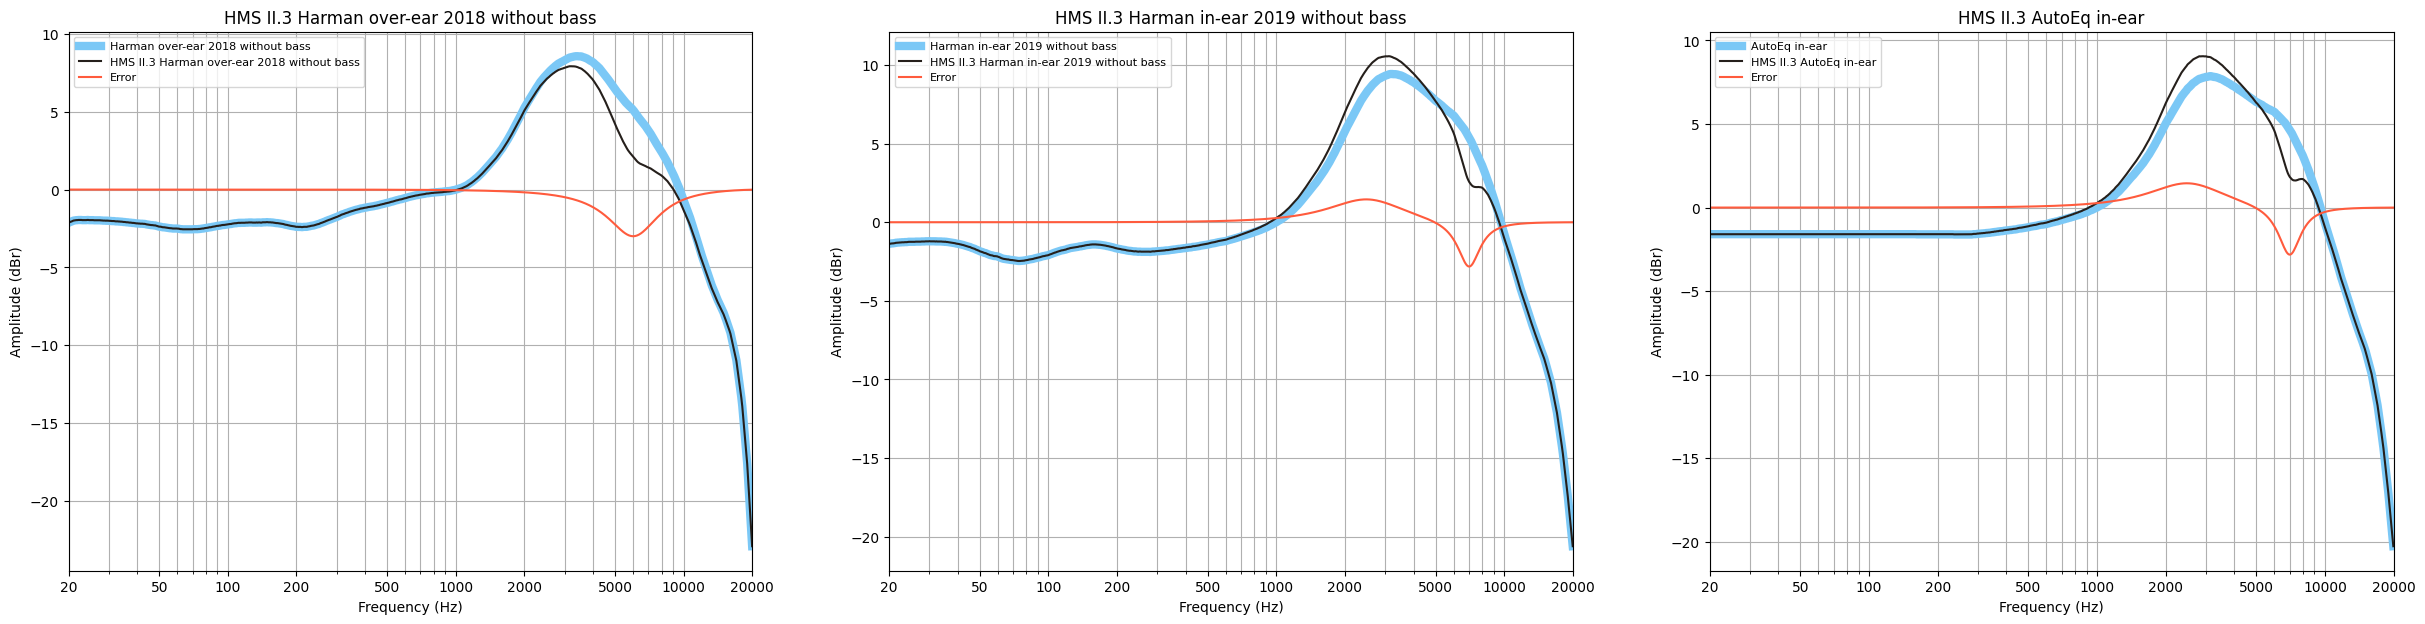

In [27]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(30, 7)

autoeq_ie = FrequencyResponse.read_csv(AUTOEQ_PATH.joinpath('targets', 'AutoEq in-ear.csv'))
i = 0
for cal, target in zip([cal_oe, cal_ie, cal_ie], [harman['over-ear'], harman['in-ear'], autoeq_ie]):
    calibrated = target.copy()
    calibrated.name = f'HMS II.3 {target.name}'
    calibrated.raw += cal.raw
    calibrated.compensate(target, min_mean_error=False)
    calibrated.plot(fig=fig, ax=axs[i], show_fig=False, raw_plot_kwargs={'label': calibrated.name}, target_plot_kwargs={'label': target.name})
    calibrated.write_csv(f'out/{calibrated.name}.csv')
    i += 1
plt.show()